This notebook is dedicated to task 2. 

Here, we conducted EDA, feature engineering, feature selection, given the time limit, we only conducted the essential EDAs that will help us complete the task, further EDA and feature engineering could be conducted given more time. 

We implemented a classfication task, we used XGBoost model, since it natively handles: class imbalance, mixed data types (numerical, categirical, boolean, etc..) and it is robust to ouliers.

The feature engineering impleemented here are ones to suits the model, i.e. we have used label encoding instead of one hot, since XGBoost will not treat them as ranking, given it is a tree-based model (which is different from models like Logistic Regression, where label encoding will lead to wrong ranking in categorical features). 

In this notebook we will have 3 sections:
1. Data Preprocessing, includes: EDA, feature engineering and feature selection
2. Model training
2. Model evaluation and feature importance

In [41]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score, precision_recall_curve)
from xgboost import XGBClassifier

In [85]:
# load dataset
df = pd.read_csv('../data/Dataset Home Task Data Scientist.csv')

In [43]:
df.head()

,user_id,registration_timestamp,email_domain,age,gender,job_title,education_level,is_smoker,is_drinker,os,device_type,registration_duration_ms,is_fraud
0,b15f6943-a626-4421-bf75-920479d48382,2025-01-01T00:00:02.650012,gmail.com,45,F,Junior,High School,False,True,ios,mobile,12441.110944,False
1,9ab3bcb0-3684-412e-b670-dabbe23677ef,2025-01-01T00:01:21.914078,gmail.com,30,M,Mid-Level,High School,False,False,windows,desktop,14321.539458,False
2,a04b21fb-e08f-444d-aa5f-0a240d0bfc9f,2025-01-01T00:02:31.383339,yahoo.com,40,M,Mid-Level,PhD,False,True,macos,desktop,12324.471495,False
3,e2cf77e1-1396-46ec-a99e-c1db2a6c4001,2025-01-01T00:02:44.511087,yahoo.com,62,M,Junior,Bachelors,False,True,windows,desktop,12401.548644,False
4,ee56a00f-96e0-43f1-b505-923ce9b162c0,2025-01-01T00:04:06.897122,outlook.com,58,M,Junior,High School,False,True,ios,mobile,10907.621773,False


In [44]:
#parse time stamps
df['registration_timestamp'] = pd.to_datetime(df['registration_timestamp'])

In [45]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_id                   50000 non-null  str           
 1   registration_timestamp    50000 non-null  datetime64[us]
 2   email_domain              50000 non-null  str           
 3   age                       50000 non-null  int64         
 4   gender                    50000 non-null  str           
 5   job_title                 50000 non-null  str           
 6   education_level           45105 non-null  str           
 7   is_smoker                 50000 non-null  bool          
 8   is_drinker                50000 non-null  bool          
 9   os                        50000 non-null  str           
 10  device_type               50000 non-null  str           
 11  registration_duration_ms  50000 non-null  float64       
 12  is_fraud                  500

In [46]:
#check missing values
df.isnull().sum()*100/df.shape[0]

user_id                     0.00
registration_timestamp      0.00
email_domain                0.00
age                         0.00
gender                      0.00
job_title                   0.00
education_level             9.79
is_smoker                   0.00
is_drinker                  0.00
os                          0.00
device_type                 0.00
registration_duration_ms    0.00
is_fraud                    0.00
dtype: float64

education_level has almost 10% of missing values

In [47]:
#check fraud counts and percentage
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100

In [48]:
fraud_pct

is_fraud
False    95.0
True      5.0
Name: proportion, dtype: float64

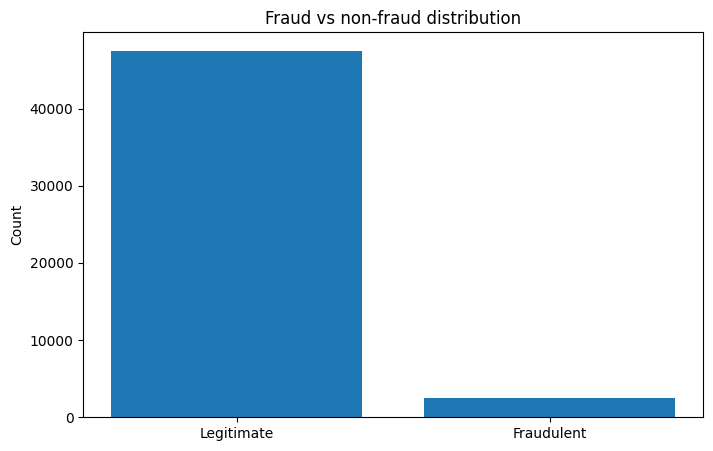

In [49]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Legitimate', 'Fraudulent'], fraud_counts.values)
plt.ylabel('Count')
plt.title('Fraud vs non-fraud distribution')
plt.savefig('../outputs/plots/fraud_rate.png')
plt.show()

In [50]:
#missing values in education level, mssingness itself is a fraud signal, fraudsters often skip fields, so we preserve it as 'Unknown' rather than hiding it with imputation
df['education_level'] = df['education_level'].fillna('Unknown')

In [51]:
df.isnull().sum()


user_id                     0
registration_timestamp      0
email_domain                0
age                         0
gender                      0
job_title                   0
education_level             0
is_smoker                   0
is_drinker                  0
os                          0
device_type                 0
registration_duration_ms    0
is_fraud                    0
dtype: int64

In [52]:
#separate features per types so we can work on each type separately
numerical_cols = ['age', 'registration_duration_ms']
categorical_cols = ['email_domain', 'gender', 'job_title', 'education_level', 
                    'os', 'device_type']
boolean_cols = ['is_smoker', 'is_drinker']

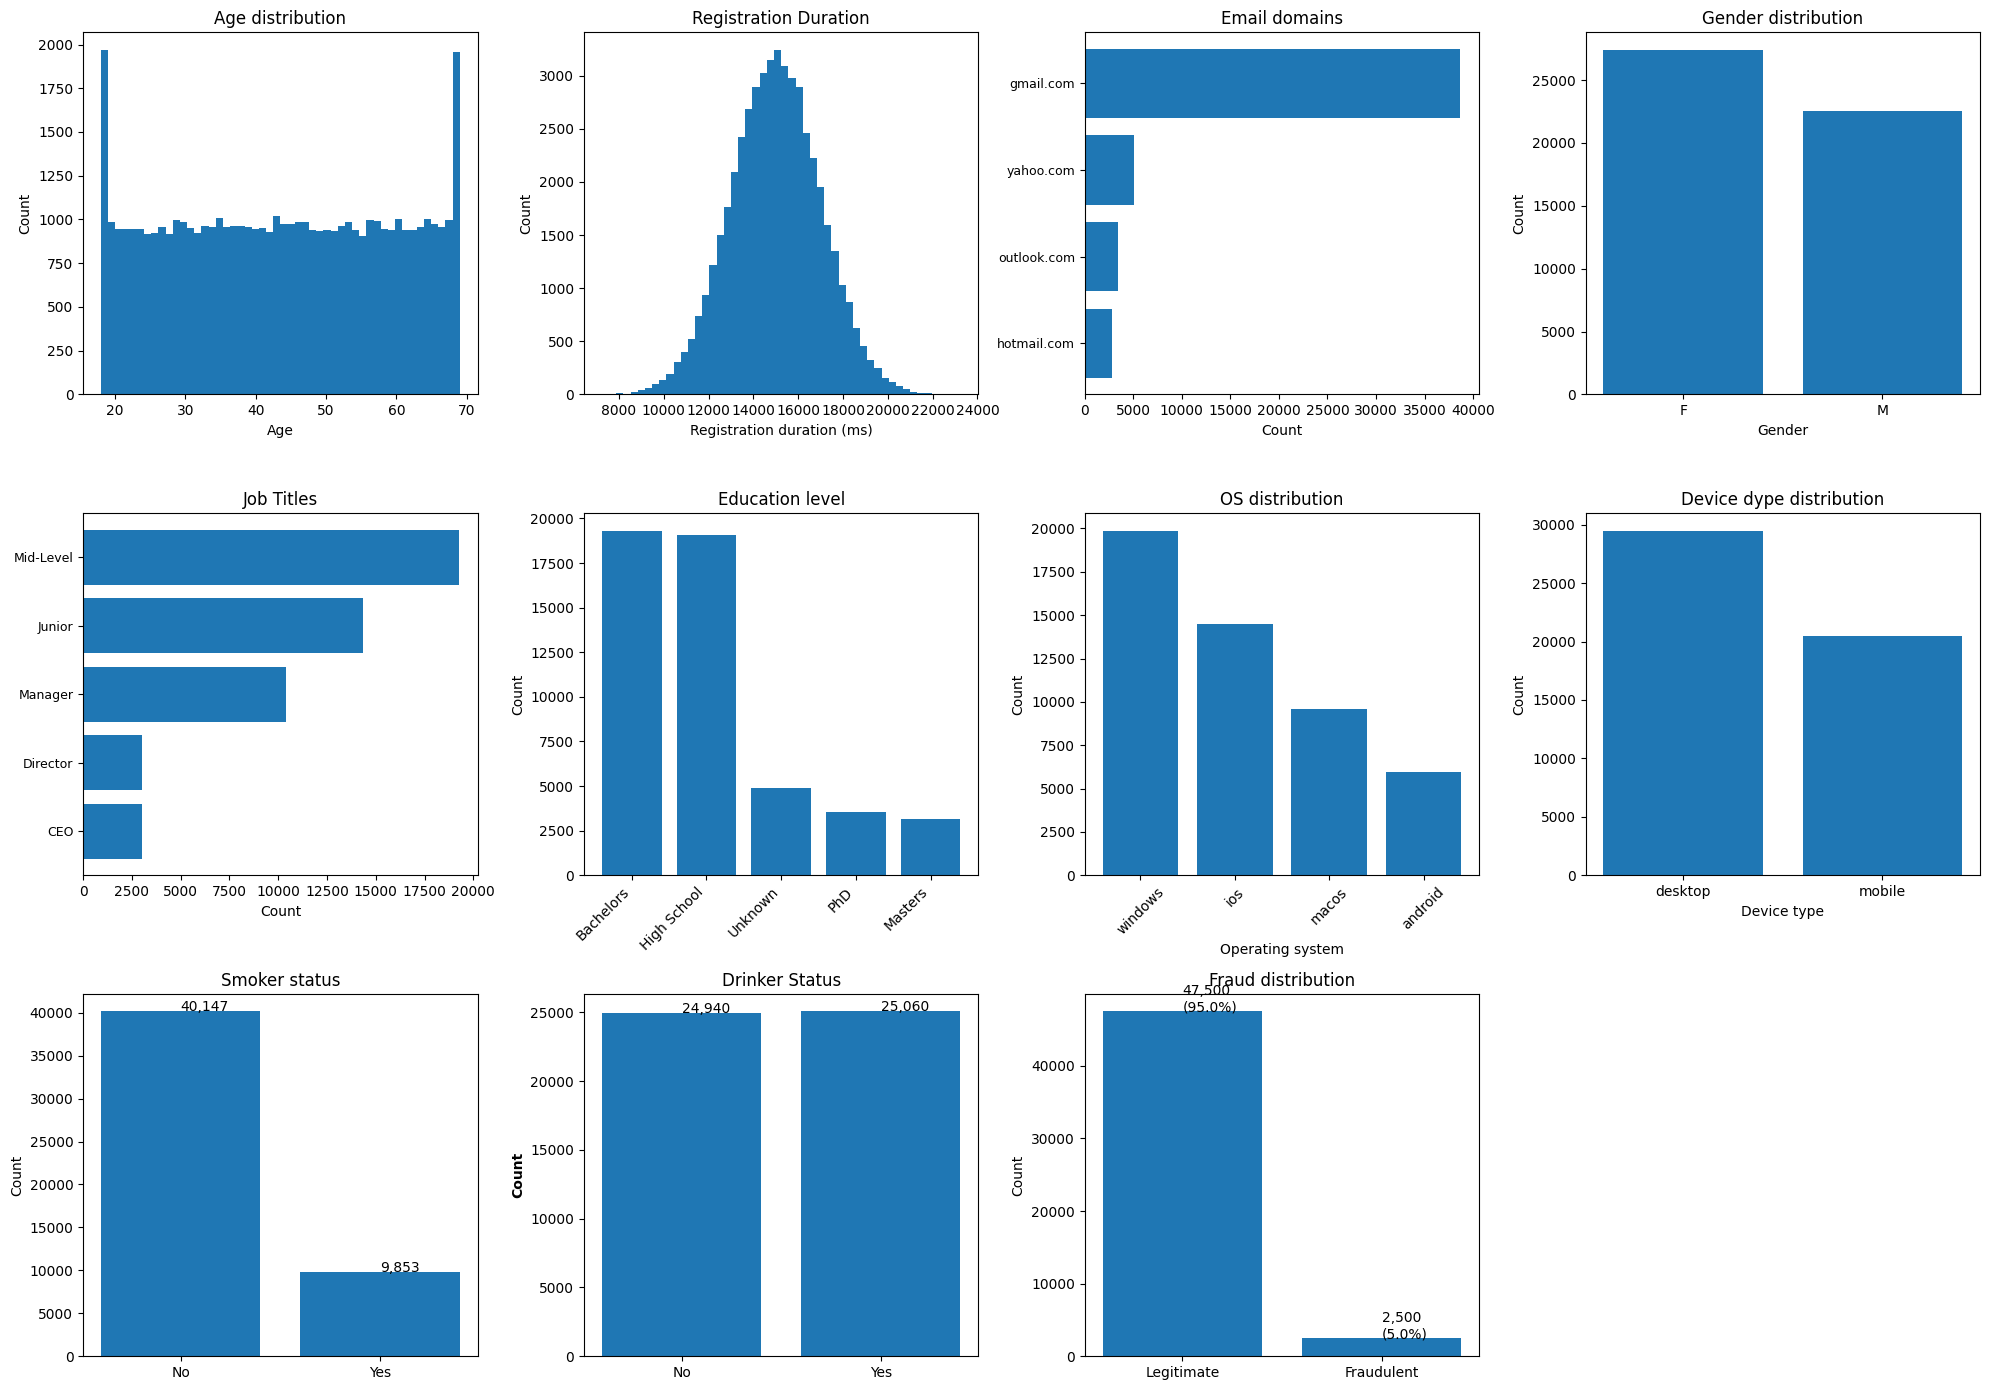

In [55]:
# rhere we want to check feature distributions
fig = plt.figure(figsize=(20, 14))
# age
ax1 = plt.subplot(3, 4, 1)
ax1.hist(df['age'], bins=50)
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
ax1.set_title('Age distribution')

# registration
ax2 = plt.subplot(3, 4, 2)
ax2.hist(df['registration_duration_ms'], bins=50)
ax2.set_xlabel('Registration duration (ms)')
ax2.set_ylabel('Count')
ax2.set_title('Registration Duration')

# email domain
ax3 = plt.subplot(3, 4, 3)
top_domains = df['email_domain'].value_counts()
ax3.barh(range(len(top_domains)), top_domains.values)
ax3.set_yticks(range(len(top_domains)))
ax3.set_yticklabels(top_domains.index, fontsize=9)
ax3.set_xlabel('Count')
ax3.set_title('Email domains')
ax3.invert_yaxis()

# Gender
ax4 = plt.subplot(3, 4, 4)
gender_counts = df['gender'].value_counts()
ax4.bar(gender_counts.index, gender_counts.values)
ax4.set_xlabel('Gender')
ax4.set_ylabel('Count')
ax4.set_title('Gender distribution')

# Job title
ax5 = plt.subplot(3, 4, 5)
top_jobs = df['job_title'].value_counts()
ax5.barh(range(len(top_jobs)), top_jobs.values)
ax5.set_yticks(range(len(top_jobs)))
ax5.set_yticklabels(top_jobs.index, fontsize=9)
ax5.set_xlabel('Count')
ax5.set_title('Job Titles')
ax5.invert_yaxis()

# Education Level
ax6 = plt.subplot(3, 4, 6)
edu_counts = df['education_level'].value_counts()
ax6.bar(range(len(edu_counts)), edu_counts.values)
ax6.set_xticks(range(len(edu_counts)))
ax6.set_xticklabels(edu_counts.index, rotation=45, ha='right')
ax6.set_ylabel('Count')
ax6.set_title('Education level')

# Operating system
ax7 = plt.subplot(3, 4, 7)
os_counts = df['os'].value_counts()
ax7.bar(os_counts.index, os_counts.values)
ax7.set_xlabel('Operating system')
ax7.set_ylabel('Count')
ax7.set_title('OS distribution')
ax7.tick_params(axis='x', rotation=45)

# Device type
ax8 = plt.subplot(3, 4, 8)
device_counts = df['device_type'].value_counts()
ax8.bar(device_counts.index, device_counts.values)
ax8.set_xlabel('Device type')
ax8.set_ylabel('Count')
ax8.set_title('Device dype distribution')

# is_smoker
ax9 = plt.subplot(3, 4, 9)
smoker_counts = df['is_smoker'].value_counts()
ax9.bar(['No', 'Yes'], [smoker_counts[False], smoker_counts[True]])
ax9.set_ylabel('Count')
ax9.set_title('Smoker status')
for i, v in enumerate([smoker_counts[False], smoker_counts[True]]):
    ax9.text(i, v, f'{v:,}')

# is_drinker
ax10 = plt.subplot(3, 4, 10)
drinker_counts = df['is_drinker'].value_counts()
ax10.bar(['No', 'Yes'], [drinker_counts[False], drinker_counts[True]])
ax10.set_ylabel('Count', fontweight='bold')
ax10.set_title('Drinker Status')
for i, v in enumerate([drinker_counts[False], drinker_counts[True]]):
    ax10.text(i, v, f'{v:,}')

# is_fraud
ax11 = plt.subplot(3, 4, 11)
fraud_counts = df['is_fraud'].value_counts()
bars = ax11.bar(['Legitimate', 'Fraudulent'], fraud_counts.values)
ax11.set_ylabel('Count')
ax11.set_title('Fraud distribution')
for i, bar in enumerate(bars):
    height = bar.get_height()
    fraud_pct = (fraud_counts.values[i] / len(df)) * 100
    ax11.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({fraud_pct:.1f}%)')

plt.tight_layout()
plt.savefig('../outputs/plots/all_features_distribution.png')
plt.show()


In [56]:
print(f"Summary Statistics:")
print(f"Total samples: {len(df):,}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Boolean features: {len(boolean_cols)}")
print(f"Unique email domains: {df['email_domain'].nunique()}")
print(f"Unique job titles: {df['job_title'].nunique()}")

Summary Statistics:
Total samples: 50,000
Numerical features: 2
Categorical features: 6
Boolean features: 2
Unique email domains: 4
Unique job titles: 5


# Feature engineering

In [57]:
# Extract time based features
df['hour'] = df['registration_timestamp'].dt.hour
df['day_of_week'] = df['registration_timestamp'].dt.dayofweek  # 0=monday, 6=sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [58]:
df.head(2)

,user_id,registration_timestamp,email_domain,age,gender,job_title,education_level,is_smoker,is_drinker,os,device_type,registration_duration_ms,is_fraud,hour,day_of_week,is_weekend
0,b15f6943-a626-4421-bf75-920479d48382,2025-01-01 00:00:02.650012,gmail.com,45,F,Junior,High School,False,True,ios,mobile,12441.110944,False,0,2,0
1,9ab3bcb0-3684-412e-b670-dabbe23677ef,2025-01-01 00:01:21.914078,gmail.com,30,M,Mid-Level,High School,False,False,windows,desktop,14321.539458,False,0,2,0


In [59]:
# Time of day flags
df['is_night_registration'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)

In [60]:
df.head(2)

,user_id,registration_timestamp,email_domain,age,gender,job_title,education_level,is_smoker,is_drinker,os,device_type,registration_duration_ms,is_fraud,hour,day_of_week,is_weekend,is_night_registration,is_business_hours
0,b15f6943-a626-4421-bf75-920479d48382,2025-01-01 00:00:02.650012,gmail.com,45,F,Junior,High School,False,True,ios,mobile,12441.110944,False,0,2,0,1,0
1,9ab3bcb0-3684-412e-b670-dabbe23677ef,2025-01-01 00:01:21.914078,gmail.com,30,M,Mid-Level,High School,False,False,windows,desktop,14321.539458,False,0,2,0,1,0


In [61]:
# Registration speed flag (it is susoicious when it is very fast, <5 seconds = 5000ms)
df['is_very_fast_registration'] = (df['registration_duration_ms'] < 5000).astype(int)


In [62]:
df.head(2)


,user_id,registration_timestamp,email_domain,age,gender,job_title,education_level,is_smoker,is_drinker,os,device_type,registration_duration_ms,is_fraud,hour,day_of_week,is_weekend,is_night_registration,is_business_hours,is_very_fast_registration
0,b15f6943-a626-4421-bf75-920479d48382,2025-01-01 00:00:02.650012,gmail.com,45,F,Junior,High School,False,True,ios,mobile,12441.110944,False,0,2,0,1,0,0
1,9ab3bcb0-3684-412e-b670-dabbe23677ef,2025-01-01 00:01:21.914078,gmail.com,30,M,Mid-Level,High School,False,False,windows,desktop,14321.539458,False,0,2,0,1,0,0


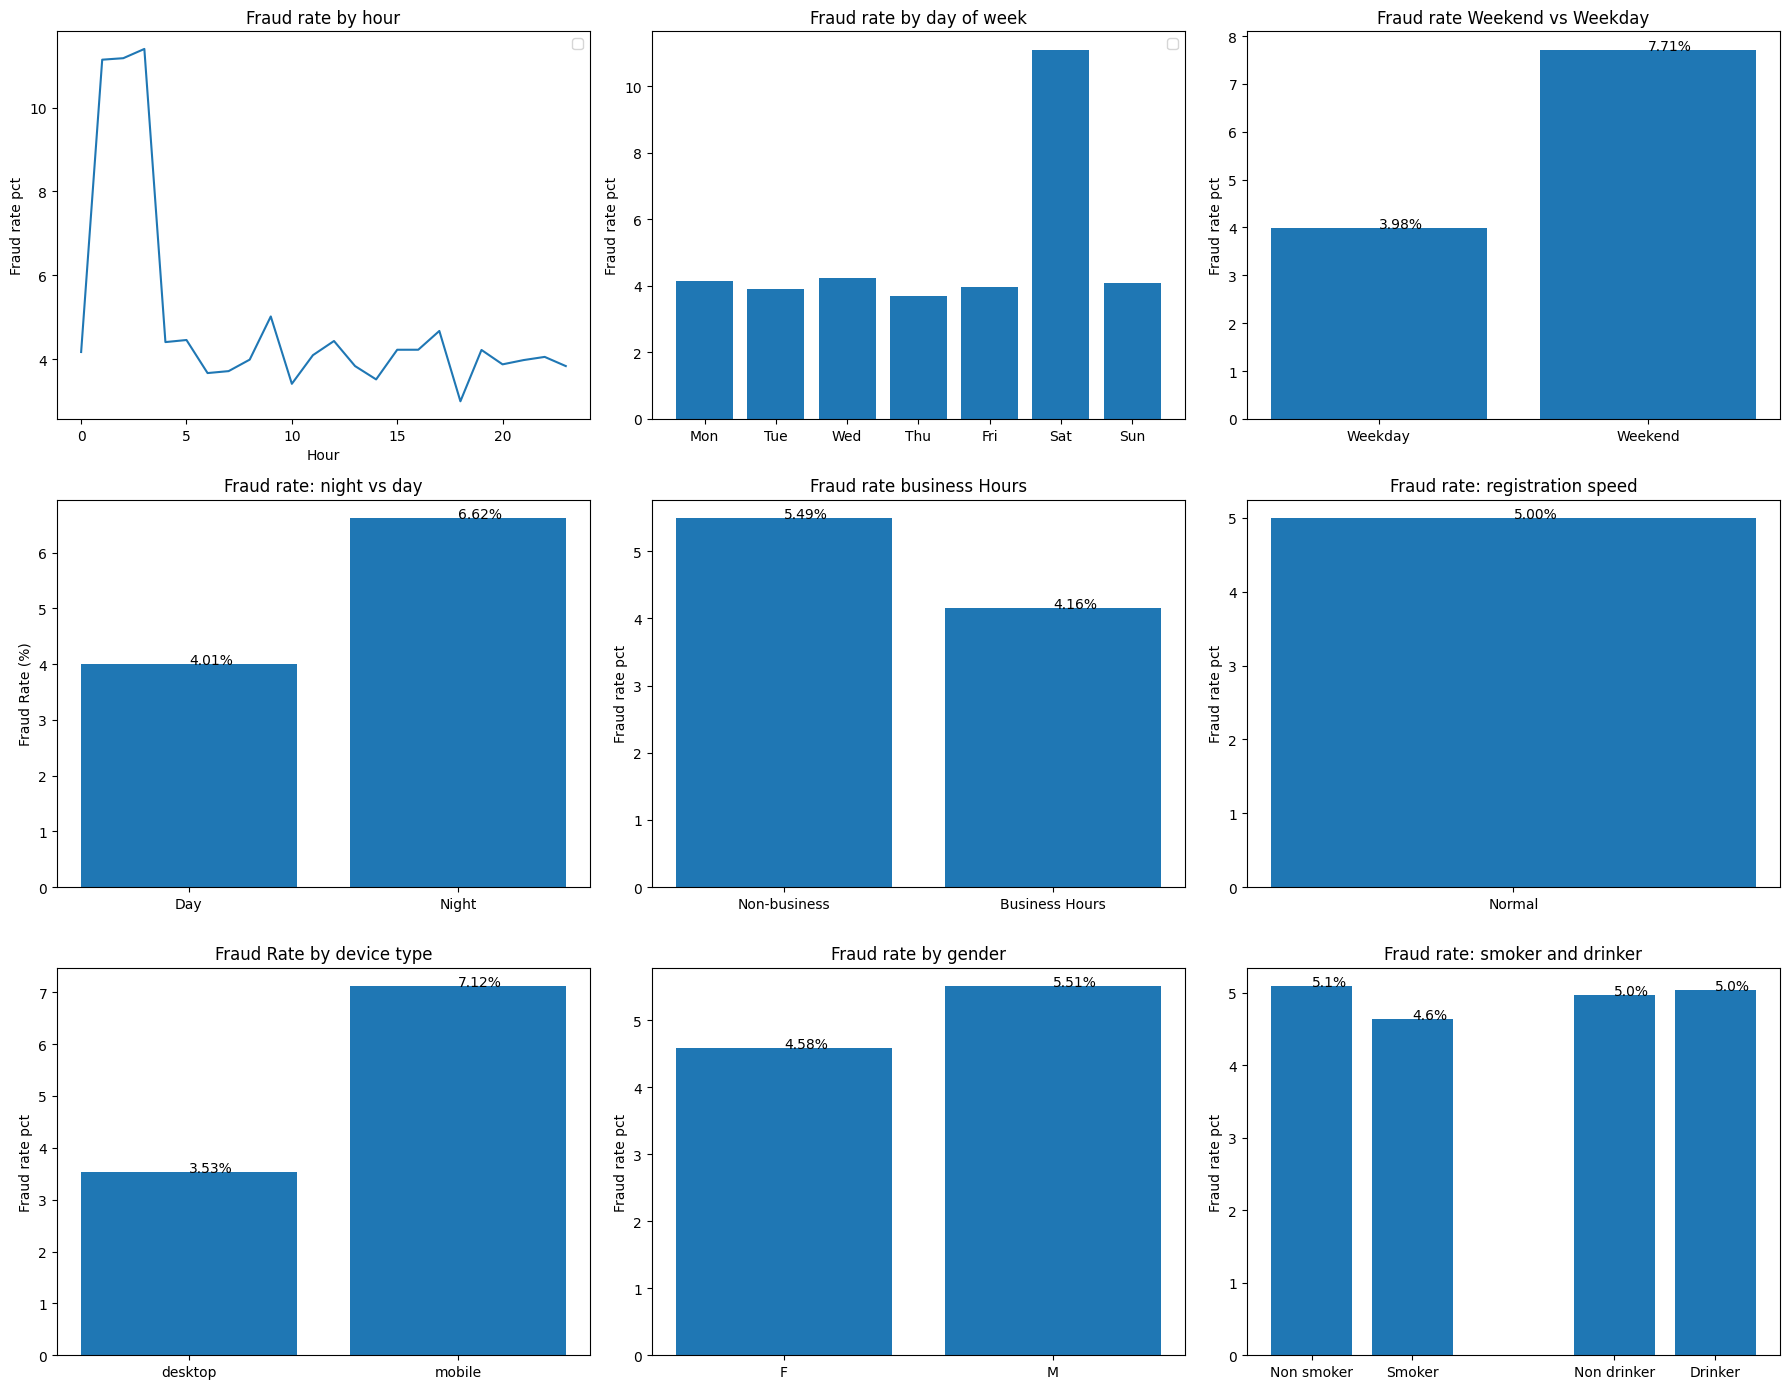

In [67]:
# We create comprehensive fraud pattern within other features, so it can later help with feature selection
fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# Fraud rate by hour
axes[0, 0].set_title('Fraud rate by hour')
hourly_fraud = df.groupby('hour')['is_fraud'].mean() * 100
axes[0, 0].plot(hourly_fraud.index, hourly_fraud.values)
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Fraud rate pct')
axes[0, 0].legend()

# Fraud rate by day of week
axes[0, 1].set_title('Fraud rate by day of week')
dow_fraud = df.groupby('day_of_week')['is_fraud'].mean() * 100
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), dow_fraud.values)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_labels)
axes[0, 1].set_ylabel('Fraud rate pct')
axes[0, 1].legend()

# Weekend vs Weekday
axes[0, 2].set_title('Fraud rate Weekend vs Weekday')
weekend_fraud = [df[df['is_weekend']==0]['is_fraud'].mean()*100, 
                 df[df['is_weekend']==1]['is_fraud'].mean()*100]
bars = axes[0, 2].bar(['Weekday', 'Weekend'], weekend_fraud)
axes[0, 2].set_ylabel('Fraud rate pct')
for bar in bars:
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%')

# night vs day registration
axes[1, 0].set_title('Fraud rate: night vs day')
night_fraud = [df[df['is_night_registration']==0]['is_fraud'].mean()*100,
               df[df['is_night_registration']==1]['is_fraud'].mean()*100]
bars = axes[1, 0].bar(['Day', 'Night'], night_fraud)
axes[1, 0].set_ylabel('Fraud Rate (%)')
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%')

# business hours vs non-business
axes[1, 1].set_title('Fraud rate business Hours')
business_fraud = [df[df['is_business_hours']==0]['is_fraud'].mean()*100,
                  df[df['is_business_hours']==1]['is_fraud'].mean()*100]
bars = axes[1, 1].bar(['Non-business', 'Business Hours'], business_fraud)
axes[1, 1].set_ylabel('Fraud rate pct')
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%')

# Very fast registration
axes[1, 2].set_title('Fraud rate: registration speed')
speed_fraud = [df[df['is_very_fast_registration']==0]['is_fraud'].mean()*100,
               df[df['is_very_fast_registration']==1]['is_fraud'].mean()*100]
bars = axes[1, 2].bar(['Normal', 'Very Fast (<5s)'], speed_fraud)
axes[1, 2].set_ylabel('Fraud rate pct')
for bar in bars:
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%')

# Device type
axes[2, 0].set_title('Fraud Rate by device type')
device_fraud = df.groupby('device_type')['is_fraud'].mean() * 100
bars = axes[2, 0].bar(device_fraud.index, device_fraud.values)
axes[2, 0].set_ylabel('Fraud rate pct')
for bar in bars:
    height = bar.get_height()
    axes[2, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%')

# Gender
axes[2, 1].set_title('Fraud rate by gender')
gender_fraud = df.groupby('gender')['is_fraud'].mean() * 100
bars = axes[2, 1].bar(gender_fraud.index, gender_fraud.values)
axes[2, 1].set_ylabel('Fraud rate pct')
for bar in bars:
    height = bar.get_height()
    axes[2, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%')

# Smoker vs drinker
axes[2, 2].set_title('Fraud rate: smoker and drinker')
lifestyle_fraud = [
    df[df['is_smoker']==False]['is_fraud'].mean()*100,
    df[df['is_smoker']==True]['is_fraud'].mean()*100,
    df[df['is_drinker']==False]['is_fraud'].mean()*100,
    df[df['is_drinker']==True]['is_fraud'].mean()*100
]
x_pos = [0, 1, 3, 4]
bars = axes[2, 2].bar(x_pos, lifestyle_fraud,)
axes[2, 2].set_xticks(x_pos)
axes[2, 2].set_xticklabels(['Non smoker', 'Smoker', 'Non drinker', 'Drinker'])
axes[2, 2].set_ylabel('Fraud rate pct')
for bar in bars:
    height = bar.get_height()
    axes[2, 2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%')

plt.tight_layout()
plt.savefig('../outputs/plots/fraud_pattern_analysis.png')
plt.show()

Based on the fraud pattern analysis across all features, we identified clear predictive signals that halped our feature selection strategy. 

The temporal features for strongest fraud indicators: early morning hours (0-2 am) with fraud rates of 11-12%

Saturday showed an 11% rate spike, and weekend registrations fraud rate of weekdays: 7.7% vs 3.9%. 

Night registrations: 10 pm to 6 am, also showed high fraud at 6.62% vs 4.01% during daytime. 

Device type: mobile devices showing almost 7% fraud rate compared to 3.5% for desktop. 

Gender showed not a strong signal between man and women. 

Several features (specifically the engineered ones) showed no predictive value: registration speed, smoker status, drinker status, and business hours, they all have fraud rates less than 0.5 percentage difference.

Based on this analysis, we eliminated four non predictive features (is_very_fast_registration, is_smoker, is_drinker, is_business_hours) to reduce noise.

The final feature set includes 12 features: age, registration_duration_ms, hour, day_of_week, is_weekend, is_night_registration, email_domain, gender, job_title, education_level, os, device_type.

## feature selection

In [68]:
features_to_drop = [
    'is_very_fast_registration', 
    'is_smoker',                   
    'is_drinker',                  
    'is_business_hours',           
    'user_id',                     
    'registration_timestamp'       
]

In [69]:
df_model = df.drop(columns=features_to_drop)

In [70]:
numerical_features = ['age', 'registration_duration_ms']
temporal_features = ['hour', 'day_of_week', 'is_weekend', 'is_night_registration']
categorical_features = ['email_domain', 'gender', 'job_title', 
                       'education_level', 'os', 'device_type']
target = 'is_fraud'

# categorical encoding

In [71]:
#label encoders
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[f'{col}_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    n_unique = df_model[col].nunique()
    print(f"{col} to {col}_encoded ({n_unique} unique values)")

email_domain to email_domain_encoded (4 unique values)
gender to gender_encoded (2 unique values)
job_title to job_title_encoded (5 unique values)
education_level to education_level_encoded (5 unique values)
os to os_encoded (4 unique values)
device_type to device_type_encoded (2 unique values)


In [72]:
#define final feature columns for modeling
feature_cols = (
    numerical_features +  
    temporal_features + 
    [f'{col}_encoded' for col in categorical_features] 
)

In [73]:
# prepare X and y
X = df_model[feature_cols]
y = df_model[target]

In [74]:
X.head()

,age,registration_duration_ms,hour,day_of_week,is_weekend,is_night_registration,email_domain_encoded,gender_encoded,job_title_encoded,education_level_encoded,os_encoded,device_type_encoded
0,45,12441.110944,0,2,0,1,0,0,2,1,1,1
1,30,14321.539458,0,2,0,1,0,1,4,1,3,0
2,40,12324.471495,0,2,0,1,3,1,4,3,2,0
3,62,12401.548644,0,2,0,1,3,1,2,0,3,0
4,58,10907.621773,0,2,0,1,2,1,2,1,1,1


In [75]:
#Split data andstratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      
    random_state=42,    
    stratify=y          
)

In [76]:
#Calculate scale_pos_weight for handling class imbalance
train_fraud_count = y_train.sum()
train_legit_count = len(y_train) - train_fraud_count
test_fraud_count = y_test.sum()
test_legit_count = len(y_test) - test_fraud_count
scale_pos_weight = train_legit_count / train_fraud_count

In [77]:
scale_pos_weight

np.float64(19.0)

### model training

In [78]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  
    n_estimators=100,                    
    max_depth=6,                         
    learning_rate=0.1,                   
    random_state=42,                     
    eval_metric='logloss'                
)

In [79]:
model.fit(X_train, y_train)

,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# MODEL EVALUATION

In [80]:
#Get predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [81]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [82]:
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall: {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:{f1:.4f}")
print(f"ROC-AUC:{roc_auc:.4f}")

Precision: 0.4213 (42.13%)
Recall: 0.8400 (84.00%)
F1-Score:0.5611
ROC-AUC:0.9586


In [83]:
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

              precision    recall  f1-score   support

  Legitimate       0.99      0.94      0.96      9500
  Fraudulent       0.42      0.84      0.56       500

    accuracy                           0.93     10000
   macro avg       0.71      0.89      0.76     10000
weighted avg       0.96      0.93      0.94     10000



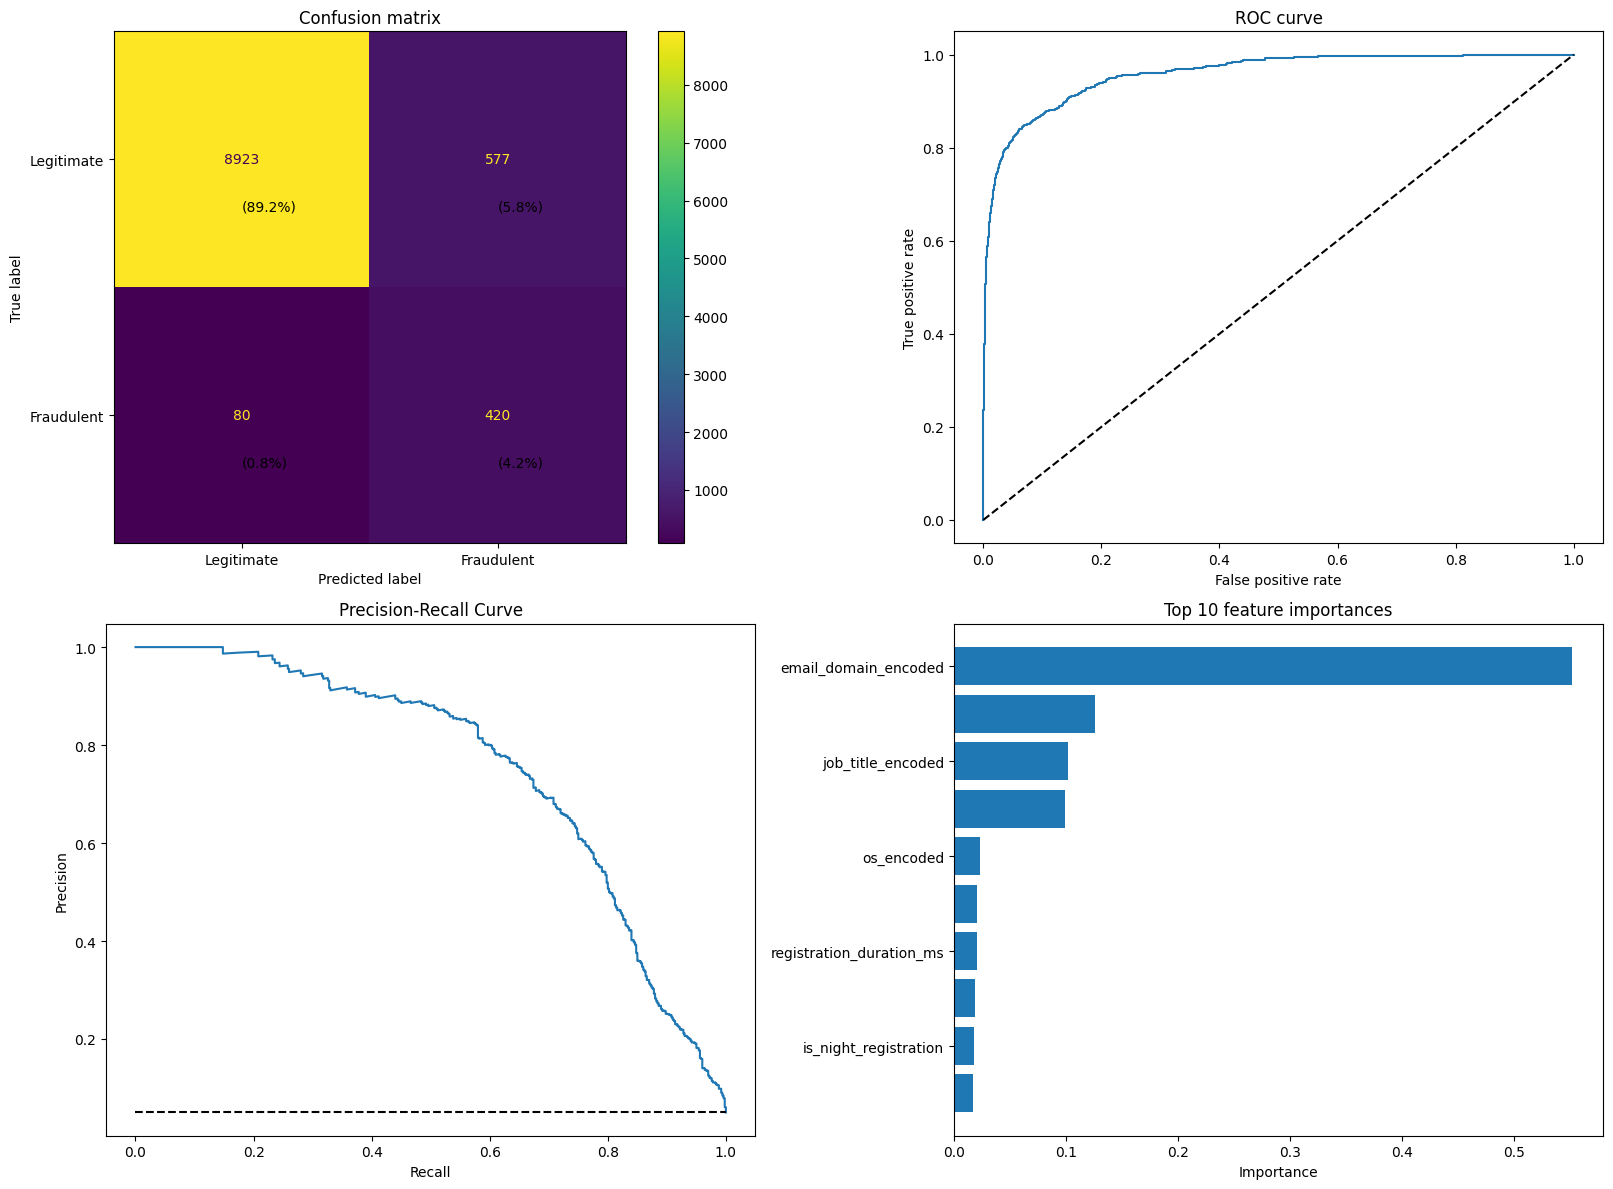

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraudulent'])
disp.plot(ax=axes[0, 0])
axes[0, 0].set_title('Confusion matrix')
#annotations with percentages
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        pct = (cm[i, j] / cm.sum()) * 100
        axes[0, 0].text(j, i + 0.2, f'({pct:.1f}%)')

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
axes[0, 1].set_xlabel('False positive rate')
axes[0, 1].set_ylabel('True positive rate')
axes[0, 1].set_title('ROC curve')
#axes[0, 1].set_xlim([0.0, 1.0])
#axes[0, 1].set_ylim([0.0, 1.05])

#PR-Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

axes[1, 0].plot(recall_curve, precision_curve, label=f'PR-Curve (AP = {avg_precision:.4f})')
baseline = y_test.sum() / len(y_test)
axes[1, 0].plot([0, 1], [baseline, baseline], 'k--',
               label=f'Baseline (AP = {baseline:.4f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
#axes[1, 0].set_xlim([0.0, 1.0])
#axes[1, 0].set_ylim([0.0, 1.05])

#feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'].values)
axes[1, 1].set_yticklabels(feature_importance['feature'].values)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 feature importances',)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/plots/model_evaluation.png')
plt.show()


## Model Performance

The XGBoost classifier achieved strong performance with a ROC-AUC of 0.9586, which means excellent ability to discriminate between fraudulent and non-fraudulent

The model successfully identified 420 out of 500 fraudsters with 84% recall, missing only 80 cases 
However, we have 577 false positives: 42% precision, which means almost 58% of fraud alerts will require human review

For fraud detection applications this tradeoff is often acceptable

The PR curve: AP = 0.75, suggests that the model handleded the 95:5 class imbalance effectively 
The confusion matrix shows the model classifies correctly 93.4% of all cases

Feature importance analysis reveals education level as the dominant predictor, followed by email domain and job title. 

Temporal features (hour, day of week, weekend) showed low importance eventhough they showed strong fraud patterns during EDA, suggesting these patterns might be already captured by other features.